In [56]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Exercise 4

Import the file **logistisch.csv**. We have the following model:

\begin{align}
f(t) = \frac{f_0 G}{f_0 + e^{-kGt}(G-f_0)}
\end{align}


## Part a)

What is the meaning of the individual parameters:

+ $G$ is the upper bound of the function
+ $(G-f_0)$ is the capacity which influences the growth of the function
+ $k$ is the growth constant
+ $f_0$ is the lower bound of the function


In [ ]:
def logistic_growth(t,f0,G,k):
    return (f0 * G) / (f0 + np.exp(-k*G*t)*(G-f0))

def plot_logistic_growth(f0,G,k):
    t = np.linspace(0,10,100)
    f = logistic_growth(t,f0,G,k)

    plt.figure(figsize=(10,6))
    plt.plot(t,f, label=f"f0={f0}, G={G}, k={k}")
    plt.xlabel("Time t")
    plt.ylabel("Population f(t)")
    plt.title("Logistic Growth")
    plt.legend()
    plt.grid(True)
    plt.show()

interact(plot_logistic_growth,
         f0 = widgets.FloatSlider(value=1, min=0, max=10, step=0.1, description="f0"),
            G = widgets.FloatSlider(value=10, min=0, max=100, step=1, description="G"),
            k = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description="k")
            )



interactive(children=(FloatSlider(value=1.0, description='f0', max=10.0), FloatSlider(value=10.0, description=…

<function __main__.plot_logistic_growth(f0, G, k)>

## Part b)

We now calculate the Parameters using Gauß Newton Algorithm

#### Implement Gauß Newton Nonlinear Least Squares


Again Gauss-Netwon Algorithm is non-linear least squares method. 

Given m functions $r = (r_1, r_2, ..., r_m)$ and n variables $\beta = (\beta_1, \beta_2, ..., \beta_n)$, the goal is to minimize the sum of the squares of the functions (here $r_i$ are the residuals):

\begin{align}
S(\beta) = \sum_{i=1}^{m} r_i^2(\beta)
\end{align}

Starting with a initial guess $\beta^{(0)}$, the method proceeds by the iterations

\begin{align}
\beta^{(k+1)} = \beta^{(k)} - (J^T J)^{-1} J^T r
\end{align}

where $J$ is the Jacobian matrix of the residuals $r_i$ with respect to the variables $\beta_j$.


Considering data fitting the goal is to find the parameters $\beta$ such that the given model function $f(x,\beta)$ fits some data points $(x_i,y_i)$ the functions $r_i$ are the residuals:

\begin{align}
r_i (\beta) = y_i - f(x_i, \beta)
\end{align}

Then the Gauss-Newton method can be expressed in terms of the Jacobian $J_f = -J_r$:

\begin{align}
\beta^{(k+1)} = \beta^{(k)} + (J_f^T J_f)^{-1} J_f^T r
\end{align}

Note that $(J_f^TJ_f)^{-1}J_f^T$ is the pseudo-inverse of the Jacobian $J_f$.




In [58]:
def gauss_newton(model,jacobian,t_data,y_data,x0,max_iter=100,tol=1e-6):
    """
    Gauss-Newton linear least squares fitting

    Args:
    model: function that takes x and t as arguments
    jacobian: jacobian of model
    t_data: array of time data
    y_data: array of y data
    x0: initial guess
    max_iter: maximum number of iterations
    tol: tolerance
    """

    x = x0.copy()
    prev_error = np.inf

    for i in range(max_iter):
        # Compute the residuals and the Jacobian
        r = y_data - model(x,t_data)
        J = jacobian(x,t_data)

        # Perform the Gauss newton Update 
        # delta x = (J^T J)^-1 J^T r 
        try:
            # Using the pseudo-inverse
            # I will hopefully implement this later
            delta_x = np.linalg.pinv(J.T @ J) @ J.T @ r
        except np.linalg.LinAlgError:
            print("Matrix inversion falied - using gradient descent")
            delta_x = 0.1 * J.T @ r # back to simple gradient descent

        x += delta_x

        # Check for convergence

        current_error = np.sum(r**2)
        if abs(prev_error - current_error) < tol:
            break
        prev_error = current_error

        return x, current_error

We now consider the model function

\begin{align}
f(t) = \frac{f_0 G}{f_0 + e^{-kGt}(G-f_0)}
\end{align}

and calculate the jacobian matrix $J_f$ of this function

\begin{align}
J_f = \begin{pmatrix}
\frac{\partial f}{\partial f_0} & \frac{\partial f}{\partial G} & \frac{\partial f}{\partial k}
\end{pmatrix}
\end{align}

define $D = f_0 + e^{-kGt}(G-f_0)$ and calculate the partial derivatives of $f$ with respect to $f_0$, $G$ and $k$

$f(t) = \frac{f_0 G}{D}$ 

\begin{align}
\frac{\partial f}{\partial f_0} = \frac{D \frac{\partial f_0}{\partial f_0} - f_0G \frac{\partial D}{\partial f_0}}{D^2} \Rightarrow \frac{G^2 e^{-kGt}}{D^2}
\end{align}

Next one 

\begin{align}
\frac{\partial f}{\partial G} = \frac{D \frac{\partial f_0}{\partial G} - f_0G \frac{\partial D}{\partial G}}{D^2} \Rightarrow  \frac{f_0^2(1-e^{-kGt}) + f_0Ge^{-kGt}kt(G-f_0)}{D^2}
\end{align}

and last one

\begin{align}
\frac{\partial f}{\partial k} = \frac{D \frac{\partial f_0}{\partial k} - f_0G \frac{\partial D}{\partial k}}{D^2} \Rightarrow \frac{f_0G^2t(G-f_0)e^{-kGt}}{D^2}
\end{align}



In [59]:
# Again implement the logistic growth model
def logistic_growth(params,t):
    f0,G,k = params
    return (f0 * G) / (f0 + np.exp(-k*G*t)*(G-f0))

# Calculate the jacobian of the logistic growth model

def jacobian_logistic_model(params,t):
    f0,G,k = params

    exponent = np.exp(-k*G*t)
    denominator = (f0 + exponent*(G-f0)) 
    denominator_sq = denominator**2

    # Partial derivatives
    df_df0 = (G**2 * exponent)/denominator_sq
    
    term1 = f0**2*(1-exponent)
    term2 = f0 * G * exponent * k * t *(G-f0)
    df_dG = (term1 + term2)/denominator_sq

    df_dk = (f0 * G**2 * t * (G-f0)*exponent)/denominator_sq

    return np.column_stack((df_df0,df_dG,df_dk))

In [60]:
# Import logistic data

data = np.genfromtxt("logistisch.csv", delimiter=",") 
print(data)

[[  0.  22.]
 [  1.  36.]
 [  2.  60.]
 [  3. 101.]
 [  4. 169.]
 [  5. 266.]
 [  6. 360.]
 [  7. 510.]
 [  8. 704.]
 [  9. 827.]
 [ 10. 928.]]


In [151]:
# We now search a range of data to obtain minimal error

# Grid Based Search

f0_range = 928
G_range = np.linspace(900,1500,10)
k_range = np.linspace(0.0001,0.001,2000)

best_params = None
best_error = np.inf

for G in G_range:
        for k in k_range:
            params = [f0,G,k]
            x, error = gauss_newton(logistic_growth,jacobian_logistic_model,data[:,0],data[:,1],params)
            if error < best_error:
                best_params = x
                best_error = error

print(f"Best parameters: {best_params}")
print(f"Best error: {best_error}")





Best parameters: [2.06289119e+01 1.13854777e+03 4.73718175e-04]
Best error: 1825.917592867235


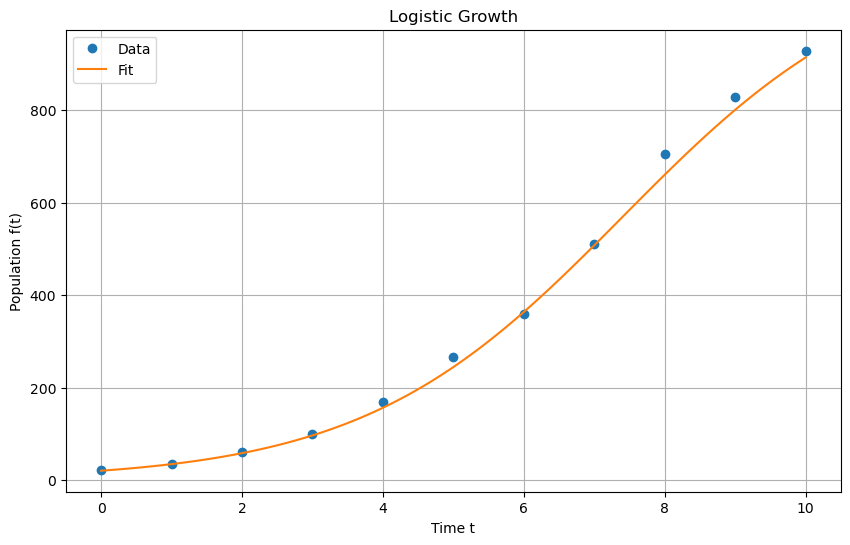

In [152]:
t_fit = np.linspace(data[:,0].min(),data[:,0].max(),100)
y_fit = logistic_growth(best_params,t_fit)

plt.figure(figsize=(10,6))
plt.plot(data[:,0],data[:,1],'o',label="Data")
plt.plot(t_fit,y_fit,label="Fit")
plt.xlabel("Time t")
plt.ylabel("Population f(t)")
plt.title("Logistic Growth")
plt.legend()
plt.grid(True)
plt.show()

## Part c)

Again we consider the logistic growth model with a given G

\begin{align}
f(t) = \frac{f_0 G}{f_0 + e^{-kGt}(G-f_0)}
\end{align}

If G is known we can the reformulate the model so that we linearize in $f_0$ and $k$:

\begin{align}
f(t) = \frac{f_0 G}{f_0 + e^{-kGt}(G-f_0)}
\end{align}

make "kehrwert" 

\begin{align}
\frac{1}{f(t)} = \frac{f_0 + e^{-kGt}(G-f_0)}{f_0 G}
\end{align}

split fraction and subsract

\begin{align}
\frac{1}{f(t)} - \frac{1}{G} = \frac{e^{-kGt}(G-f_0)}{f_0 G}
\end{align}

apply logarithm

\begin{align}
ln(\frac{1}{f(t)} - \frac{1}{G}) = ln(\frac{e^{-kGt}(G-f_0)}{f_0 G})
\end{align}


logarithmin rules

\begin{align}
ln(\frac{1}{f(t)} - \frac{1}{G}) = -kGt + ln(\frac{G-f_0}{f_0 G})
\end{align}




finally we linearize by 

\begin{align}
y(t) = ln(\frac{1}{f(t)} - \frac{1}{G})
\end{align}

\begin{align}
b = -kG
\end{align}

\begin{align}
a = ln(\frac{G-f_0}{f_0 G}) = ln(\frac{G}{f_0} - 1)
\end{align}

so if we have $a$ and $b$ from the model we get

\begin{align}
k = -\frac{b}{G}
\end{align}

\begin{align}
f_0 = \frac{G}{e^a + 1}
\end{align}

In [153]:
t_data = data[:,0]
f_data = data[:,1]

G_guess = 1100

y_transformed = np.log(1/f_data - 1/G_guess)

Implement Linear regression and fit the model

\begin{align}
y  = a + bx + \epsilon
\end{align}

Object is to find the straight line that minimizes the sum of squared errors

\begin{align}
SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{align}

where $\hat{y}_i = a + bx_i$

Derive the Slope by

\begin{align}
SSE = \sum_{i=1}^{n} (y_i - a - bx_i)^2
\end{align}

Set the partial derivatives to zero

\begin{align}
\frac{\partial SSE}{\partial a} = -2 \sum_{i=1}^{n} (y_i - a - bx_i) = 0 \\
\sum y_i = na + b \sum x_i
\end{align}

\begin{align}
\frac{\partial SSE}{\partial b} = -2 \sum_{i=1}^{n} x_i(y_i - a - bx_i) = 0 \\
\sum x_i y_i = a \sum x_i + b \sum x_i^2
\end{align}

From normal equation 1 we get parameter a

\begin{align}
a = \frac{\sum y_i - b \sum x_i}{n}
\end{align}

For solving b we substitute a into normal equation 2 

\begin{align}
b = \frac{n\sum x_i y_i - \sum x_i \sum y_i}{n\sum x_i^2 - (\sum x_i)^2}
\end{align}


This can be written in terms of covariance and variance

\begin{align}
b = \frac{cov(x,y)}{var(x)} \\
cov(x,y) = \frac{1}{n} \sum (x_i - \bar{x})(y_i - \bar{y}) \\
var(x) = \frac{1}{n} \sum (x_i - \bar{x})^2
\end{align}


Estimated f0: 1050.2686137618025
Estimated k: 0.000507659936602166


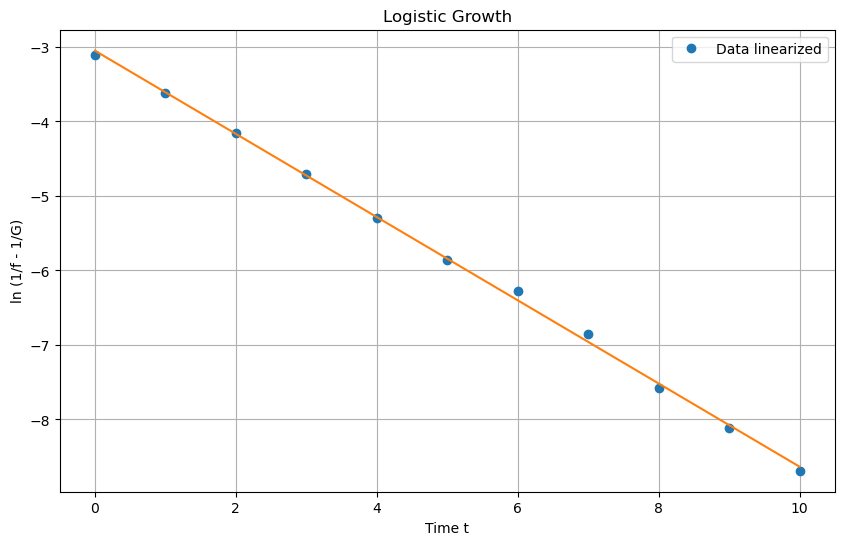

In [158]:
def linear_regression(x,y):
    """  
    Computes the slope (b) and the intercept (a) for model
    """
    n = len(x)
    x_mean, y_mean = np.mean(x), np.mean(y)

    # calculate covariance and variance

    cov = np.sum((x - x_mean)*(y - y_mean))
    var = np.sum((x - x_mean)**2)

    b = cov / var
    a = y_mean - b * x_mean

    return a,b

a,b = linear_regression(t_data,y_transformed)

k_estimate = -b / G_guess
f0_estimate = G_guess / (np.exp(a) + 1)

print(f"Estimated f0: {f0_estimate}")
print(f"Estimated k: {k_estimate}")

t_fit = np.linspace(t_data.min(),t_data.max(),100)
y_fit = a + b * t_fit

plt.figure(figsize=(10,6))
plt.plot(t_data,y_transformed,'o',label="Data linearized")
plt.plot(t_fit,y_fit)
plt.xlabel("Time t")
plt.ylabel("ln (1/f - 1/G)")
plt.title("Logistic Growth")
plt.legend()
plt.grid(True)
plt.show()

# Aufgabe 5

Import of the file **biochemie.csv**, this is a dataset of the Feulgen-Hydrolyse of the DNA

We have the model

\begin{align}
\phi(t) = \frac{p_1p_2}{p_2-p_3}(e^{-p_3t}-e^{-p_2t})
\end{align}

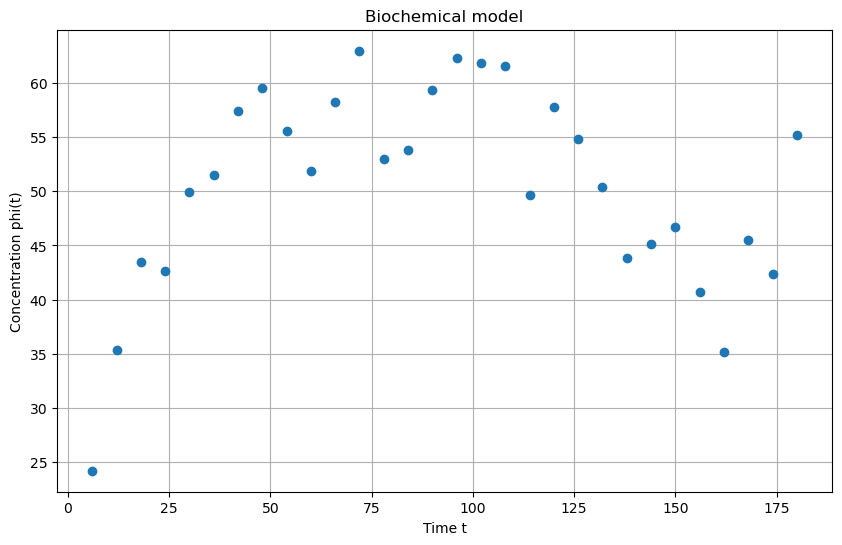

In [ ]:
# First of again we need to get a feel for the parameters

biochemie_data = np.genfromtxt("biochemie.csv",delimiter=",")
t_data = biochemie_data[:,0]
phi_data = biochemie_data[:,1]

plt.figure(figsize=(10,6))
plt.plot(t_data,phi_data,'o')
plt.xlabel("Time t")
plt.ylabel("Concentration phi(t)")
plt.title("Biochemical model")
plt.grid(True)
plt.show()



Lets again derive the Jacobian matrix $J_f$ of this function

\begin{align}
J_f = \begin{pmatrix}
\frac{\partial f}{\partial p_1} & \frac{\partial f}{\partial p_2} & \frac{\partial f}{\partial p_3}
\end{pmatrix}
\end{align}

Define $D = p_2 - p_3$ which leads to 

\begin{align}
\phi(t) = \frac{p_1p_2}{D}(e^{-p_3t}-e^{-p_2t})
\end{align}

First of calculate $p_1$

\begin{align}
\frac{\partial \phi}{\partial p_1} = \frac{p_2}{D}(e^{-p_3t}-e^{-p_2t})
\end{align}

For $p_2$ we need the quotient rule

\begin{align}
\frac{\partial \phi}{\partial p_2} = p_1 [\frac{(1)(D) - p_2(1)}{D^2}](e^{-p_3t}-e^{-p_2t}) + \frac{p_1p_2}{D}(te^{-p_2t}) \\ 
= -\frac{p_1p_2}{D^2}(e^{-p_3t}-e^{-p_2t}) + \frac{p_1p_2}{D}(te^{-p_2t})
\end{align}

Again for $p_3$ we need the quotient rule

\begin{align}
\frac{\partial \phi}{\partial p_3} = \frac{p_1p_2(-1)}{D^2}(e^{-p_3t}-e^{-p_2t}) + \frac{p_1p_2}{D}(-te^{-p_3t}) \\
= -\frac{p_1p_2}{D^2}(e^{-p_3t}-e^{-p_2t}) - \frac{p_1p_2}{D}(te^{-p_3t})
\end{align}

In [164]:
# define jacobian of biochemical model

def biochemical_model(params,t):
    p1,p2,p3 = params
    return (p1*p2 / (p2-p3)) * (np.exp(-p3*t) - np.exp(-p2*t))

def jacobian_biochemical_model(params,t):
    p1,p2,p3 = params

    D = p2 - p3
    term = np.exp(-p3*t) - np.exp(-p2*t)

    dphi_dp1 = (p2 / D) * term
    dphi_dp2 = (p1*p3 / D**2) * term + (p1*p2*t/D) * np.exp(-p2*t)
    dphi_dp3 = -(p1*p2 / D**2) * term - (p1*p2*t/D) * np.exp(-p3*t)

    return np.column_stack((dphi_dp1,dphi_dp2,dphi_dp3))

/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1*p2 / (p2-p3)) * (np.exp(-p3*t) - np.exp(-p2*t))
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:5: RuntimeWarning: invalid value encountered in multiply
  return (p1*p2 / (p2-p3)) * (np.exp(-p3*t) - np.exp(-p2*t))
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  dphi_dp1 = (p2 / D) * term
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:13: RuntimeWarning: invalid value encountered in multiply
  dphi_dp1 = (p2 / D) * term
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  dphi_dp2 = (p1*p3 / D**2) * term + (p1*p2*t/D) * np.exp(-p2*t)
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_

Matrix inversion falied - using gradient descent


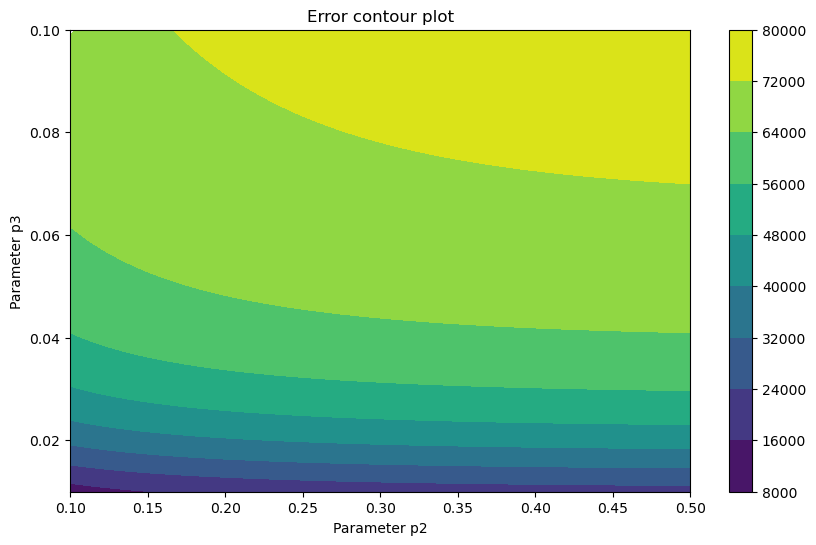

In [190]:
# Contour plot with fixed parameter

fixed_p1 = 100

p2_range = np.linspace(0.1,0.5,100)
p3_range = np.linspace(0.01,0.1,100)


error_matrix = np.zeros((len(p2_range),len(p3_range)))
                        
for i,p2 in enumerate(p2_range):
    for j,p3 in enumerate(p3_range):
        params = [fixed_p1,p2,p3]
        x,error = gauss_newton(biochemical_model,jacobian_biochemical_model,t_data,phi_data,params)
        error_matrix[i,j] = error

P2,P3 = np.meshgrid(p2_range,p3_range)

plt.figure(figsize=(10,6))
plt.contourf(P2,P3,error_matrix.T)
plt.xlabel("Parameter p2")
plt.ylabel("Parameter p3")
plt.title("Error contour plot")
plt.colorbar()
plt.show()


From this first part we see if $p_1 = 100, $p_2 = 0.1$ and $p_3 = 0.01$.

We can now make a grid based search with this new ranges

In [199]:
p1_range = np.linspace(50,150,20)
p2_range = np.linspace(0.001,0.1,20)
p3_range = np.linspace(0.001,0.01,20)

for p1 in p1_range:
    for p2 in p2_range:
        for p3 in p3_range:
            params = [p1,p2,p3]
            x,error = gauss_newton(biochemical_model,jacobian_biochemical_model,t_data,phi_data,params)
            if error < best_error:
                best_params = x
                best_error = error

print(f"Best parameters: {best_params}")
print(f"Best error: {best_error}")


/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (p1*p2 / (p2-p3)) * (np.exp(-p3*t) - np.exp(-p2*t))
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:5: RuntimeWarning: invalid value encountered in multiply
  return (p1*p2 / (p2-p3)) * (np.exp(-p3*t) - np.exp(-p2*t))
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  dphi_dp1 = (p2 / D) * term
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:13: RuntimeWarning: invalid value encountered in multiply
  dphi_dp1 = (p2 / D) * term
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_7885/2751388553.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  dphi_dp2 = (p1*p3 / D**2) * term + (p1*p2*t/D) * np.exp(-p2*t)
/var/folders/zl/tr4yyt811072b_l4prllbb4m0000gn/T/ipykernel_

Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Matrix inversion falied - using gradient descent
Best parameters: [7.

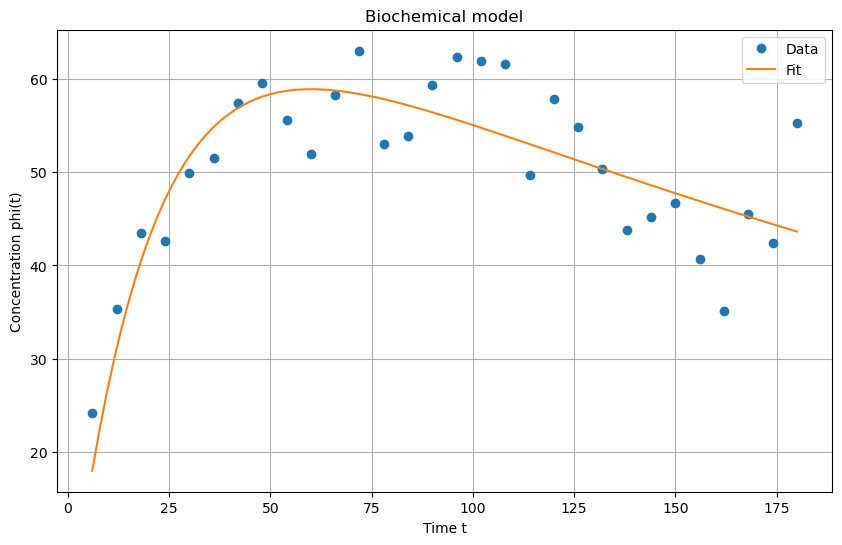

In [200]:
# Calculate the model

t_fit = np.linspace(t_data.min(),t_data.max(),100)
phi_fit = biochemical_model(best_params,t_fit)

plt.figure(figsize=(10,6))
plt.plot(t_data,phi_data,'o',label="Data")
plt.plot(t_fit,phi_fit,label="Fit")
plt.xlabel("Time t")
plt.ylabel("Concentration phi(t)")
plt.title("Biochemical model")
plt.legend()
plt.grid(True)
plt.show()


### Part b)

Use the transformation $s_1:=p_1p_2 ~ s_2:= \sqrt{p_3} ~ s_3 = \sqrt{\frac{p2-p3}{2}}$  

+ How does the model function change?
+ Calculate the Parameters again?
+ Why does this transformation help?

\begin{align}
\phi(t) = \frac{s_1}{s_2^2}(e^{-s_2^2t}-e^{-(s_3^2 + s_2^2)t})
\end{align}

